<a href="https://colab.research.google.com/github/harshjoshi23/Object_segmentation_TF/blob/main/2ndCamVid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:

!pip install segmentation-models-pytorch
!pip install torch torchvision
!pip install albumentations # For Data Augmentation
!pip install matplotlib


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Prep :

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [5]:

class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transforms=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transforms = transforms
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# Define transformations for training and validation
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Update paths according to your structure
train_dataset = CamVidDataset(
    images_dir='/content/drive/MyDrive/CamVid/train',
    masks_dir='/content/drive/MyDrive/CamVid/train_labels',
    transforms=train_transform
)

val_dataset = CamVidDataset(
    images_dir='/content/drive/MyDrive/CamVid/val',
    masks_dir='/content/drive/MyDrive/CamVid/val_labels',
    transforms=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Custom Dataset Class: CamVidDataset

## Overview
`CamVidDataset` handles loading images and masks for the CamVid dataset, with specific transformations applied to the training and validation datasets using albumentations.

## Transforms

### Train Transforms
The `train_transform` includes augmentations such as flips and normalization to enhance the diversity and generalizability of the training data.

### Validation Transforms
The `val_transform` focuses on resizing and normalization, ensuring that the validation data remains consistent for accurate performance evaluation.

## DataLoaders

### Train Loader
The `train_loader` shuffles and loads the training data, facilitating effective learning by ensuring the model encounters a varied sample of the data during training.

### Validation Loader
The `val_loader` loads validation data without shuffling, maintaining the sequence of data for consistent validation performance checks.


## **Step 3: Define the Segmentation Model**


In [6]:
#We define the FPN model with a ResNet34 encoder.
import segmentation_models_pytorch as smp



In [7]:

model = smp.FPN(
    encoder_name="resnet34",        # Choose encoder
    encoder_weights="imagenet",     # Use pretrained weights
    decoder_pyramid_channels=256,   # Number of convolution filters in FPN
    decoder_segmentation_channels=128,  # Number of filters in segmentation blocks
    decoder_merge_policy='add',     # Merge policy (options: 'add', 'cat')
    decoder_dropout=0.2,            # Spatial dropout rate
    in_channels=3,                  # Number of input channels (RGB)
    classes=32,                     # Number of output classes (CamVid has 32 classes)
    activation='softmax'            # Activation function
)


## **Step 4: Define the Training and Validation Loop**

> Add blockquote



In [8]:
# More imports :
import torch
import torch.nn as nn
import torch.optim as optim
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU

In [9]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from segmentation_models_pytorch.utils.losses import DiceLoss
# from segmentation_models_pytorch.utils.metrics import IoU

# # Define the loss function and optimizer
# loss_fn = DiceLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# iou_metric = IoU(threshold=0.5)

# # Training loop
# def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=25):
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for images, masks in train_loader:
#             images = images.to(device)
#             masks = masks.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = loss_fn(outputs, masks)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * images.size(0)

#         train_loss = train_loss / len(train_loader.dataset)

#         model.eval()
#         val_loss = 0.0
#         iou_score = 0.0
#         with torch.no_grad():
#             for images, masks in val_loader:
#                 images = images.to(device)
#                 masks = masks.to(device)
#                 outputs = model(images)
#                 loss = loss_fn(outputs, masks)
#                 val_loss += loss.item() * images.size(0)
#                 iou_score += iou_metric(outputs, masks).item() * images.size(0)

#         val_loss = val_loss / len(val_loader.dataset)
#         iou_score = iou_score / len(val_loader.dataset)

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {iou_score:.4f}')

# # Move model to device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Reduce number of workers to avoid multiprocessing issues
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# # Train the model
# train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=25)


### **Loss function and optimizer**

In [10]:
# Define the loss function and optimizer
loss_fn = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
iou_metric = IoU(threshold=0.5)

## Training and Validation Process Description

## Loss Function

**DiceLoss**: Measures the overlap between predicted and ground truth masks.

## Optimizer

**Adam**: Optimizer for updating model parameters.

## Training Loop

- `model.train()`: Sets the model to training mode.
- `optimizer.zero_grad()`: Clears the gradients.
- `outputs = model(images)`: Forward pass.
- `loss.backward()`: Backward pass to compute gradients.
- `optimizer.step()`: Updates the model parameters.
- `train_loss += loss.item() * images.size(0)`: Accumulates training loss.

## Validation Loop

- `model.eval()`: Sets the model to evaluation mode.
- `with torch.no_grad()`: Disables gradient computation.
- `iou_score += iou_metric(outputs, masks).item() * images.size(0)`: Accumulates IoU score.

## Device Handling

- Moves model and data to GPU if available for faster computation.


### **Training The model**

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU

# Define the loss function and optimizer
loss_fn = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
iou_metric = IoU(threshold=0.5)

# Training loop
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            # Ensure output and masks have the same shape
            if outputs.shape != masks.shape:
                outputs = torch.sigmoid(outputs)  # Assuming binary segmentation
                outputs = outputs[:, 0, :, :].unsqueeze(1)  # Adjust according to your case

            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        model.eval()
        val_loss, iou_score = 0.0, 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                if outputs.shape != masks.shape:
                    outputs = torch.sigmoid(outputs)  # Assuming binary segmentation
                    outputs = outputs[:, 0, :, :].unsqueeze(1)  # Adjust according to your case
                loss = loss_fn(outputs, masks)
                val_loss += loss.item() * images.size(0)
                iou_score += iou_metric(outputs, masks).item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        iou_score /= len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {iou_score:.4f}')




In [12]:
## DNT CODE

# def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=25):
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for images, masks in train_loader:
#             images, masks = images.to(device), masks.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             # Ensure output and masks have the same shape
#             if outputs.shape != masks.shape:
#                 outputs = torch.sigmoid(outputs)  # Assuming binary segmentation
#                 outputs = outputs[:, 0, :, :].unsqueeze(1)  # Adjust according to your case

#             loss = loss_fn(outputs, masks)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * images.size(0)

#         train_loss /= len(train_loader.dataset)
#         model.eval()
#         val_loss, iou_score = 0.0, 0.0
#         with torch.no_grad():
#             for images, masks in val_loader:
#                 images, masks = images.to(device), masks.to(device)
#                 outputs = model(images)
#                 if outputs.shape != masks.shape:
#                     outputs = torch.sigmoid(outputs)  # Assuming binary segmentation
#                     outputs = outputs[:, 0, :, :].unsqueeze(1)  # Adjust according to your case
#                 loss = loss_fn(outputs, masks)
#                 val_loss += loss.item() * images.size(0)
#                 iou_score += iou_metric(outputs, masks).item() * images.size(0)

#         val_loss /= len(val_loader.dataset)
#         iou_score /= len(val_loader.dataset)

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {iou_score:.4f}')


# # Move model to device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)


# # Train the model

# train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=25)



### **Moving the model to device**

In [13]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



### **Training The model**

In [14]:
# Train the model
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10) # Change num epoches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/10, Train Loss: -10.4749, Val Loss: -10.3583, IoU: -1.1527
Epoch 2/10, Train Loss: -10.5621, Val Loss: -10.3583, IoU: -1.1527
Epoch 3/10, Train Loss: -10.5620, Val Loss: -10.3583, IoU: -1.1527
Epoch 4/10, Train Loss: -10.5621, Val Loss: -10.3583, IoU: -1.1527
Epoch 5/10, Train Loss: -10.5621, Val Loss: -10.3583, IoU: -1.1527
Epoch 6/10, Train Loss: -10.5621, Val Loss: -10.3583, IoU: -1.1527
Epoch 7/10, Train Loss: -10.5621, Val Loss: -10.3583, IoU: -1.1527
Epoch 8/10, Train Loss: -10.5621, Val Loss: -10.3583, IoU: -1.1527
Epoch 9/10, Train Loss: -10.5620, Val Loss: -10.3583, IoU: -1.1527
Epoch 10/10, Train Loss: -10.5620, Val Loss: -10.3583, IoU: -1.1527


Below is correct

## **Step 5: Evaluating the Model**


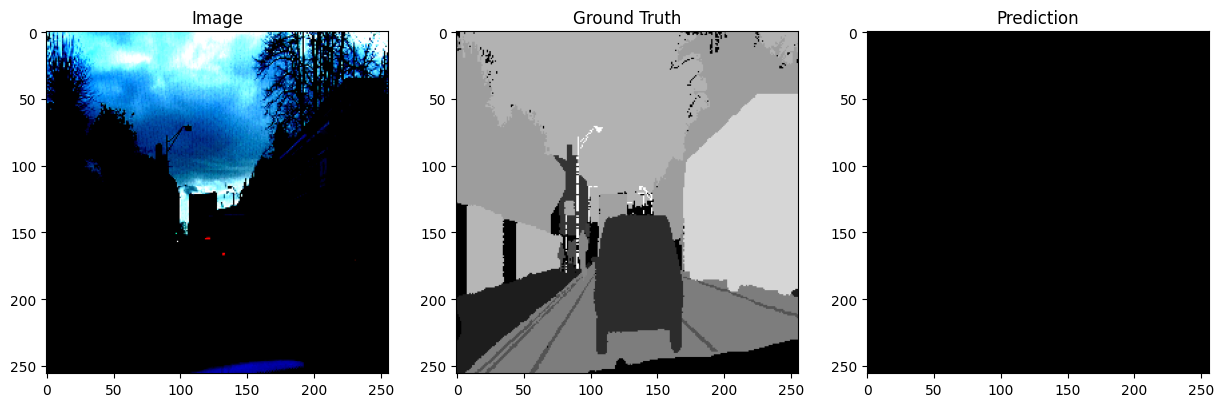

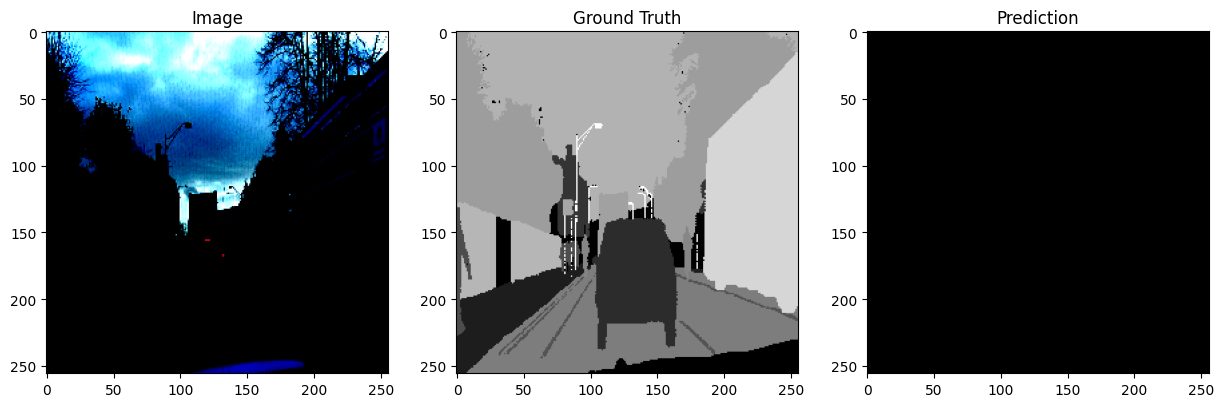

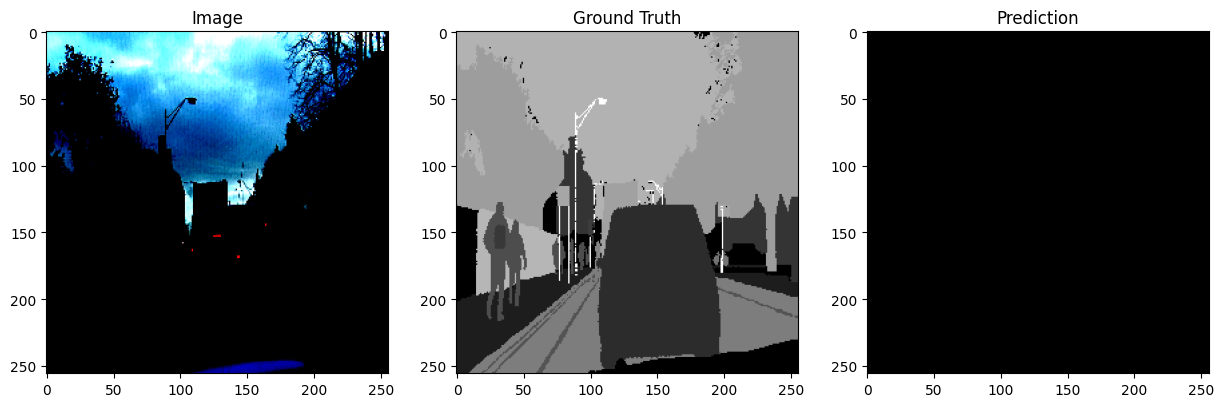

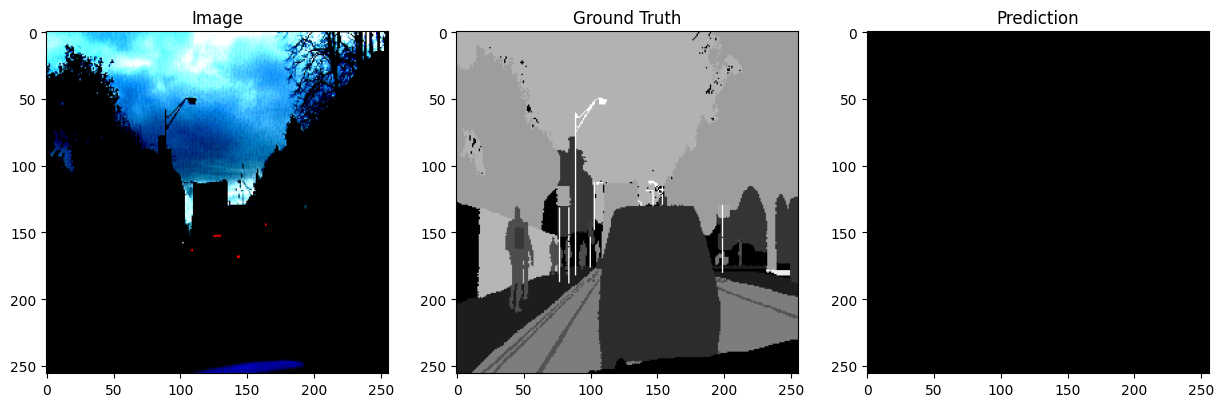

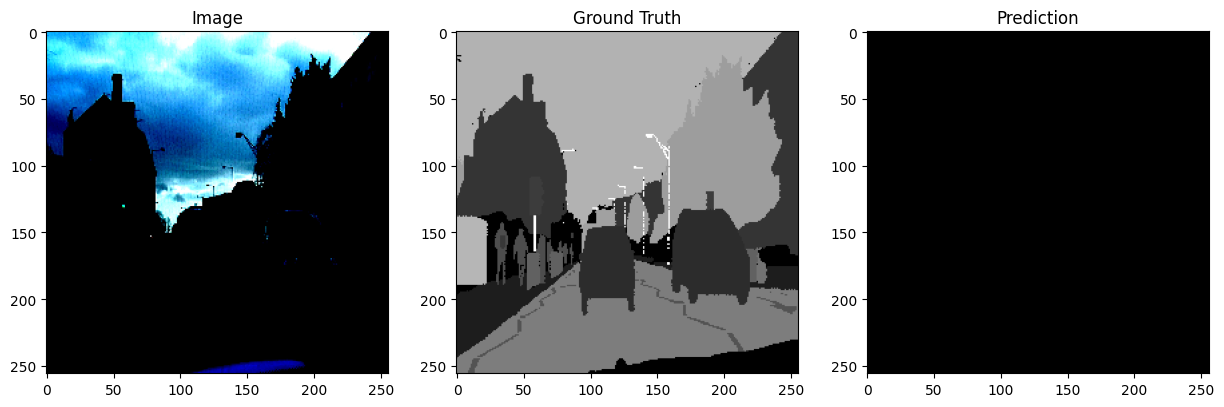

In [17]:
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()
    for i in range(num_samples):
        image, mask = dataset[i]
        image = image.to(device).unsqueeze(0)
        with torch.no_grad():
            output = model(image)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))
        ax[0].set_title('Image')
        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title('Ground Truth')
        ax[2].imshow(pred_mask, cmap='gray')
        ax[2].set_title('Prediction')
        plt.show()

# Visualize predictions
visualize_predictions(model, val_dataset, num_samples=5)


## Model Prediction Visualization

## Functionality

**visualize_predictions**: Visualizes the model's predictions.

## Process Steps

- `model.eval()`: Sets the model to evaluation mode.
- `image.to(device).unsqueeze(0)`: Moves the image to the device and adds a batch dimension.
- `torch.no_grad()`: Disables gradient computation.
- `torch.argmax(output, dim=1).squeeze().cpu().numpy()`: Gets the predicted mask.
- `plt.subplots`: Creates subplots for visualization.
- `ax[i].imshow`: Displays the image, ground truth mask, and predicted mask.


## **Step 6: Make Predictions on New Data**

In [16]:
def predict(model, image_path):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    augmented = transform(image=image)
    image = augmented['image'].to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(image)

    pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Prediction')
    plt.show()

# Predict on a new image
predict(model, '/content/drive/MyDrive/Study/Projects/AI_Joshi/CamVid/test/your_test_image.png')


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
